**OBJECTIVE:** Prepare OSM S4 dataset for modelling with modSAR algorithm

In [1]:
import math
import numpy as np
import pandas as pd

# Import relevant modSAR classes 
from modSAR.network_algorithms import ModSAR
from modSAR.cdk_utils import CDKUtils
from modSAR.datasource import GenericFileDataSource
from modSAR.preprocessing import *
from modSAR.dataset import QSARDataset, QSARDatasetIO

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Geometry
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole 

#from gevent import monkey
#monkey.patch_all()

# 2.5uM in Log units
CUTOFF_ACTIVITY = - np.log10(2.5e-06)

%matplotlib inline

# Load Data

In [2]:
# Read annotated training set compiled by wvanhoorn 
#  https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/1#issuecomment-523037719

X = pd.read_excel('/mnt/data/Master Chemical List - annotated.xlsx')
X = X[X["OSM_ID"] != 'OSM-S-424'].copy()
X['pIC50'] = -np.log10(X['Value']* 1e-06)
X.shape

(439, 21)

In [3]:
# Save this preprocessed dataset
X.to_excel('/mnt/data/malaria_osm4_train.xlsx')

In [3]:
# Read the bioactivities in a more standard way with modSAR package

malaria_osm4 = GenericFileDataSource(target_id='malaria_osm4', 
                                     filepath='/mnt/data/malaria_osm4_train.xlsx', 
                                     smiles_column='Canonical_Smiles', 
                                     compound_id_column='OSM_ID', 
                                     activity_column='pIC50',
                                     apply_filter=False)

In [24]:
malaria_osm4.bioactivities_df.query("OSM_ID == 'OSM-S-424'")['Canonical_Smiles'].values

array([], dtype=object)

In [25]:
malaria_osm4.bioactivities_df.head(3)

,Unnamed: 0,OSM_ID,Series,Assay,Value,Qualifier,PfaI EC50 (Inh),Pfal IC50 (GSK),Pfal IC50 (Syngene),Pfal IC50 (Dundee),Pfal IC50 (Avery),Pfal (K1) IC50 (Avery),Pfal IC50 (Ralph),Pfal IC50 (Guy),Pfal (K1) IC50 (Guy),Pfal IC50 (Batra),Pfal (K1) IC50 (Batra),Pfal (3D7) IC50 (Broad),Pfal (Dd2) IC50 (Broad),Canonical_Smiles,InChIKey,pIC50
0,0,OSM-A-1,1,Pfal IC50 (Guy),3.050,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.050,4.379,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,ODRSSOQWOHNABY-MOSHPQCFSA-N,5.515700
1,1,OSM-A-1,1,Pfal (K1) IC50 (Guy),4.379,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.050,4.379,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,ODRSSOQWOHNABY-MOSHPQCFSA-N,5.358625
2,2,OSM-A-2,1,Pfal IC50 (Guy),0.574,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.574,1.829,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,LXPLFPVISCVJSC-BKUYFWCQSA-N,6.241088


In [7]:
print("Number of compounds: %d | Number of unique compounds: %d" %
      (malaria_osm4.bioactivities_df.shape[0], malaria_osm4.bioactivities_df['OSM_ID'].nunique()))

Number of compounds: 439 | Number of unique compounds: 347


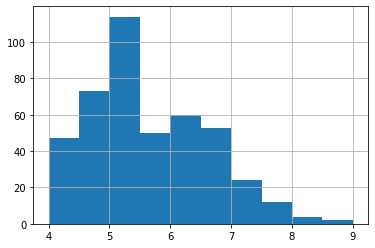

In [8]:
malaria_osm4.bioactivities_df['pIC50'].hist()

# Creating QSARDatasets

The modSAR package contains code to calculate molecular descriptors, which will generate a python object - a `QSARDataset` - that can be more easily manipulated than loose DataFrames or loose CSV files.

To build a dataset, we use `data_obj.build_qsar_dataset` method either one of two options:

1. `type="cdk"`: to calculate 200+ molecular descriptors with the CDK library v2 as features to the model
2. `type="ecfp4"`: to calculate ECFP4 fingerprints with 1024 bits and use those bits as features to the model


The method **build_qsar_dataset** method also performs a couple of preprocessing steps:
  1. Treats duplicated values: Duplicated compounds are discarded if standard deviation of the group is $sd(pIC_{50}) > 1$. Otherwise, the median value of activity is used. 
  2. Calculates Molecular Descriptors: Using CDK library (Java) or ECFP4 fingerprints with RDKit
  3. Returns a QSARDataset: a python object that encapsulates a full dataset

# Features = molecular descriptors with CDK

Use CDK molecular descriptors as features to the Machine Learning model

In [4]:
osm4_cdk_dataset = malaria_osm4.build_qsar_dataset(type="cdk", calculate_similarity=False)

CDK Bridge process running
(01/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.WHIMDescriptor()
(02/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.BCUTDescriptor()
(03/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.XLogPDescriptor()
(04/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.WeightDescriptor()
(05/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.RuleOfFiveDescriptor()
(06/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.RotatableBondsCountDescriptor()
(07/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.MannholdLogPDescriptor()
(08/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.LargestPiSystemDescriptor()
(09/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.LargestChainDescriptor()
(10/49) Collecting descriptors from class self.cdk.qsar.descriptors

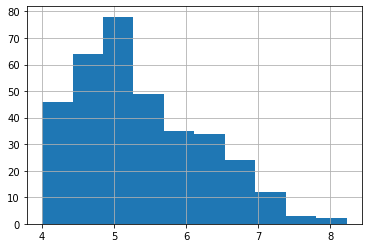

In [28]:
osm4_cdk_dataset.y.hist()

**Save Dataset**

In [5]:
QSARDatasetIO.write(osm4_cdk_dataset, filepath='/mnt/data/OSM-S4/osm4_qsardataset_cdk.xls')

**Load saved Dataset** 

In [ ]:
# QSARDatasetIO.load(dataset_name='OSM4',
#                    activity_sheetname='activity',
#                    smiles_column='Canonical_Smiles',
#                    id_column='OSM_ID',
#                    filepath='/mnt/data/OSM-S4/osm4_qsardataset_cdk.xls',
#                    calculate_similarity=False)

# Features = Morgan fingerprints

## radius = 2 

Calculate circular Morgan fingerprints with radius=2 (close to ECFP4 binary fingerprints) with RDkit and use it as features to the Machine Learning model

In [4]:
osm4_morgan2_dataset = malaria_osm4.build_qsar_dataset(type="morgan2", calculate_similarity=False)

**Save Dataset**

In [5]:
QSARDatasetIO.write(osm4_morgan2_dataset, filepath='/mnt/data/OSM-S4/osm4_qsardataset_morgan2.xls')

**Load saved Dataset** 

In [10]:
# QSARDatasetIO.load(dataset_name='OSM4',
#                    activity_sheetname='activity',
#                    smiles_column='Canonical_Smiles',
#                    id_column='OSM_ID',
#                    filepath='/mnt/data/OSM-S4/osm4_qsardataset_ecfp4.xls',
#                    calculate_similarity=False)

## radius = 4

By increasing the radius, we let the fingerprint represent longer chains which might be desirable in a ML model.

In [6]:
osm4_morgan4_dataset = malaria_osm4.build_qsar_dataset(type="morgan4", calculate_similarity=False)

**Save Dataset**

In [7]:
QSARDatasetIO.write(osm4_morgan4_dataset, filepath='/mnt/data/OSM-S4/osm4_qsardataset_morgan4.xls')

**Load saved Dataset** 

In [10]:
# QSARDatasetIO.load(dataset_name='OSM4',
#                    activity_sheetname='activity',
#                    smiles_column='Canonical_Smiles',
#                    id_column='OSM_ID',
#                    filepath='/mnt/data/OSM-S4/osm4_qsardataset_ecfp4.xls',
#                    calculate_similarity=False)